# Validation of ECG filter

In [210]:
def ECG_filter(seg, method, srate):
    if method == 'bandpass':
        import scipy.signal
        sos = scipy.signal.butter(5, [1,40], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    # lowess랑 수학적으로 동일한데 더 빠름 - 대신 계수 체크 필요
    elif method == 'savgol':
        import scipy.signal
        return seg - scipy.signal.savgol_filter(seg, 1151, 3)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T

    else:
        print('not a valid filter')
        return seg

    
def PPG_filter(seg, method, srate):
    if method == 'bandpass':
        import scipy.signal
        sos = scipy.signal.butter(5, [1,40], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T
    
    else:
        print('not a valid filter')
        return seg

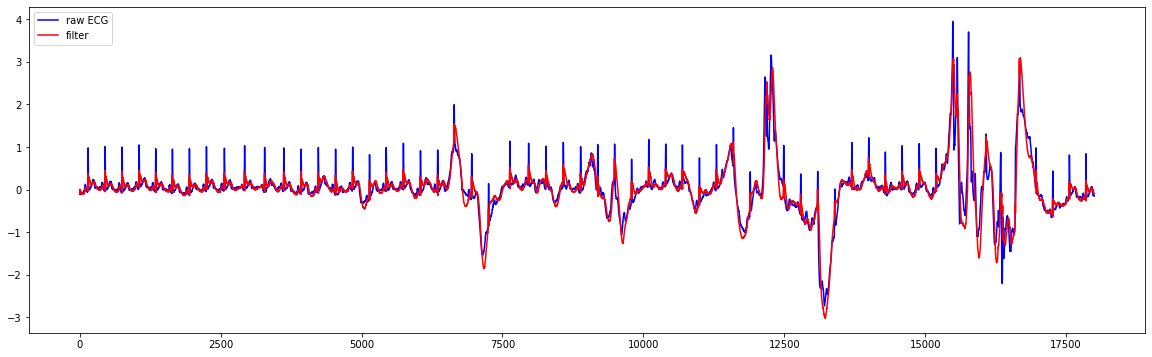

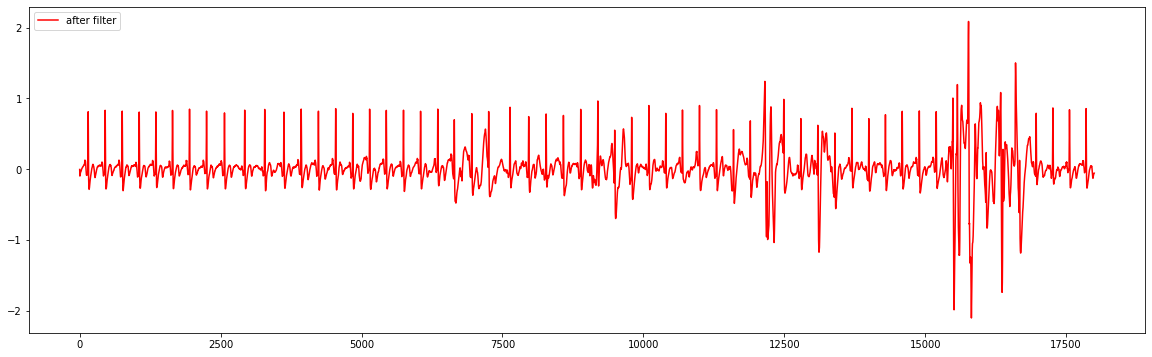

In [240]:
import scipy.signal

caseid = 5566 #1413
vals = np.load(f'{file_path}/{caseid}.npz')
seg_ecg = vals['nECG']


nseg = 300 * 60
plt.figure(figsize=(20,6))
plt.plot(seg_ecg[:nseg], c='b', label='raw ECG')
#plt.show()

#filt_seg = seg_ecg - scipy.signal.savgol_filter(seg_ecg, 1351, 3)
#filt_seg = ECG_filter(seg_ecg, 'lowess', 300)
sos = scipy.signal.butter(3, [1,47], 'bandpass', output='sos', fs=300)
#a = scipy.signal.firwin(11, 0.67, pass_zero='highpass')
#w,h = scipy.signal.freqz(a,1)

filt_seg = scipy.signal.sosfilt(sos, seg_ecg)
plt.plot((seg_ecg-filt_seg)[:nseg], c='r', label = 'filter')
#plt.plot(scipy.signal.savgol_filter(seg_ecg, 951, 3)[:nseg], c='b')
#plt.plot(scipy.signal.savgol_filter(seg_ecg, 1151, 3)[:nseg], c='g')
#plt.plot(scipy.signal.savgol_filter(seg_ecg, 1351, 3)[:nseg], c='y')

plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(20,6))
plt.plot(filt_seg[:nseg], c='r', label='after filter')
plt.legend(loc='upper left')

## Power spectral density of ECG

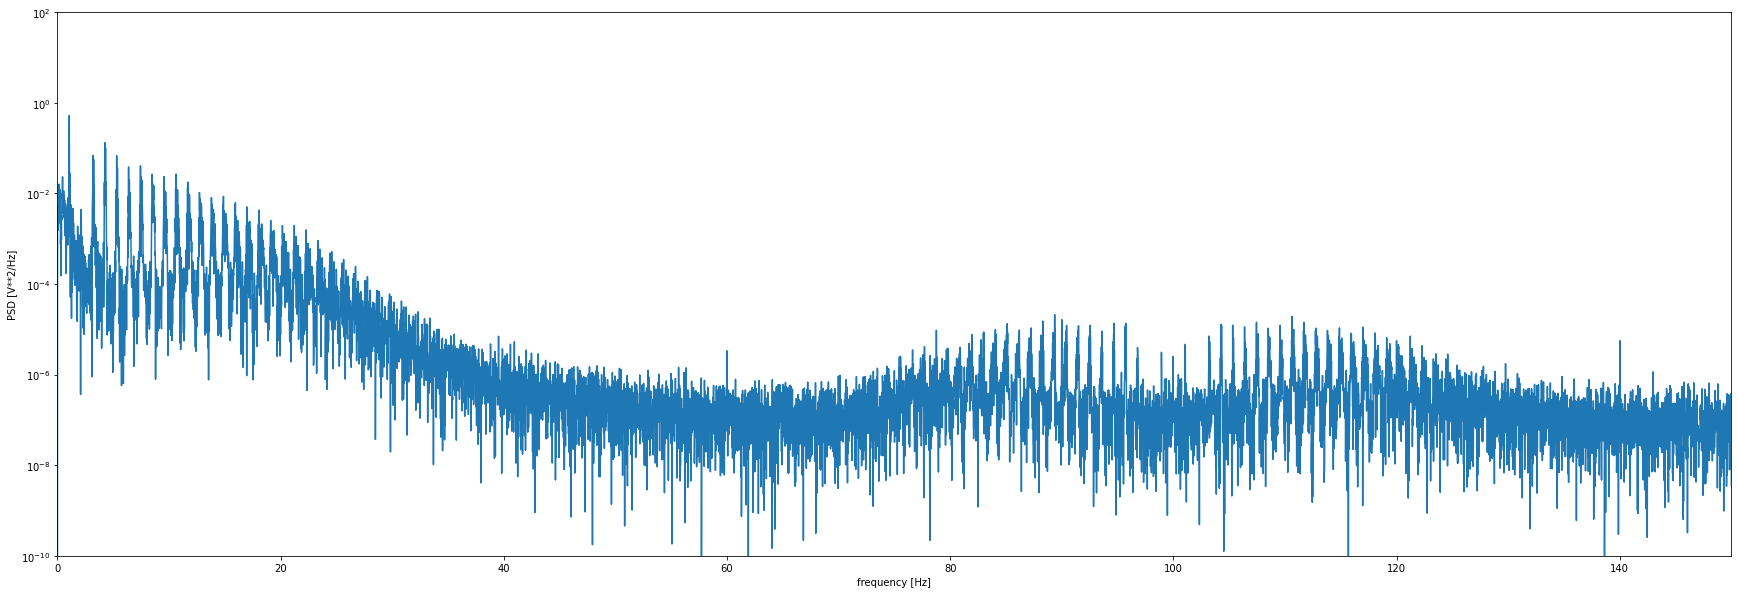

In [121]:
import scipy.signal

# f contains the frequency components
# S is the PSD
(f, S) = scipy.signal.periodogram(seg_ecg, SRATE, scaling='density')
 
plt.figure(figsize=(30,10))
plt.semilogy(f, S)
plt.ylim([1e-10, 1e2])
plt.xlim([0,150])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

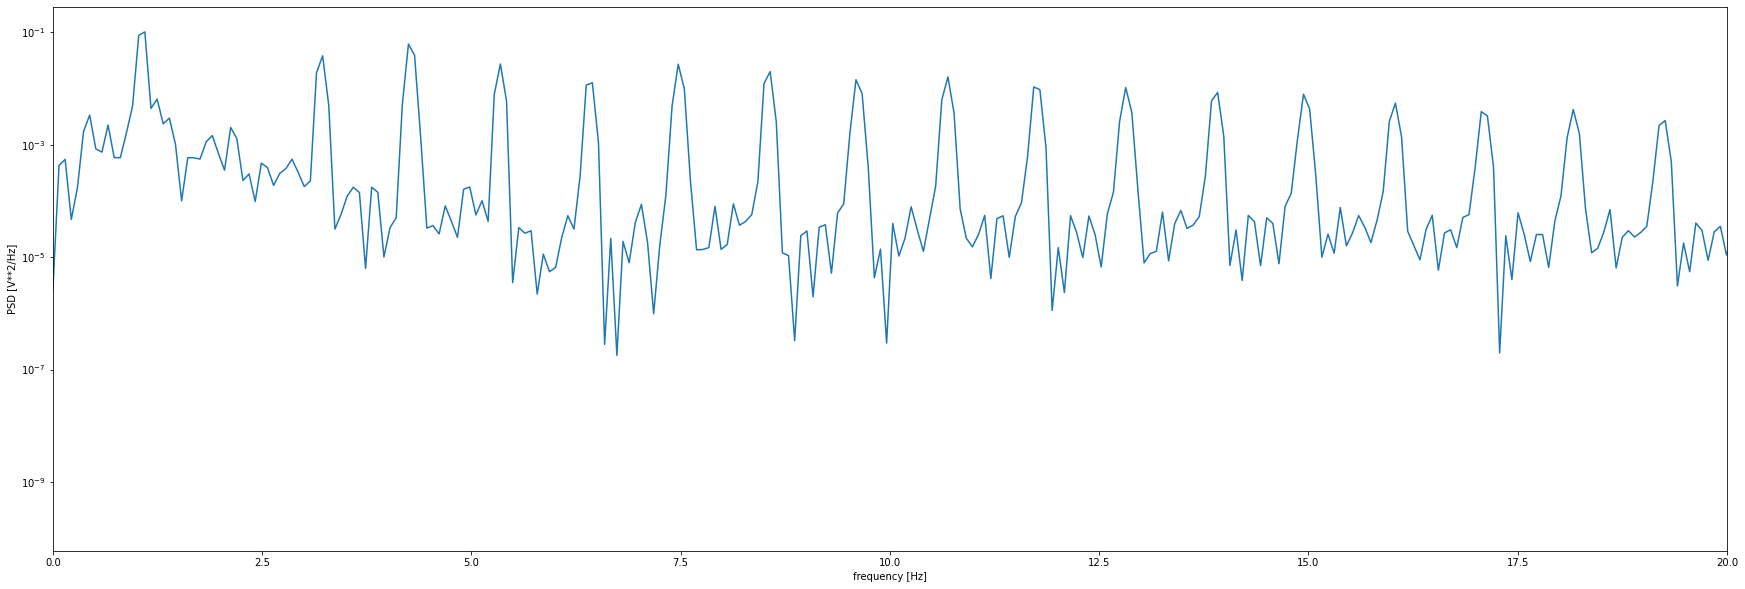

In [128]:
(f, S)= scipy.signal.welch(seg_ecg[:6000], SRATE, nperseg=1024*4)

plt.figure(figsize=(30,10))
plt.semilogy(f, S)
plt.xlim([0, 20])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## peak validation

caseid 6095


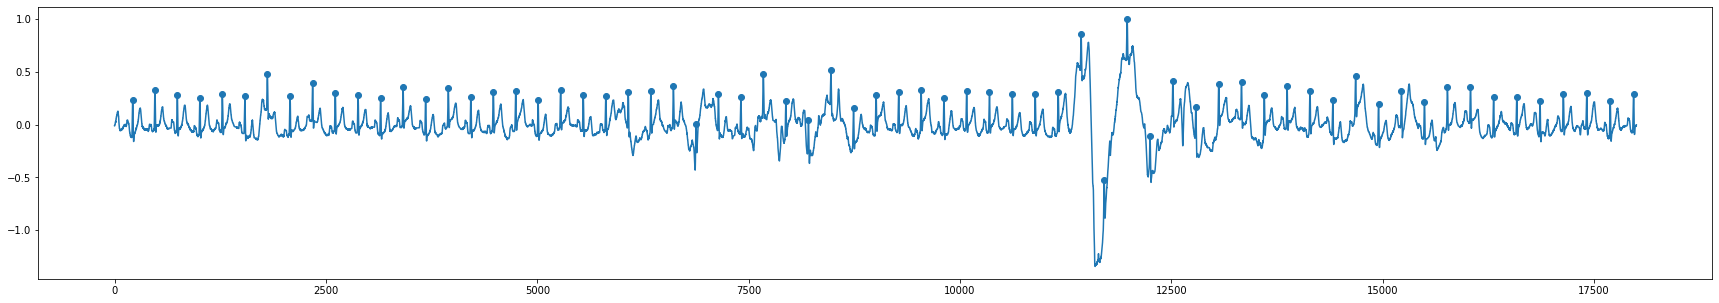

caseid 3991


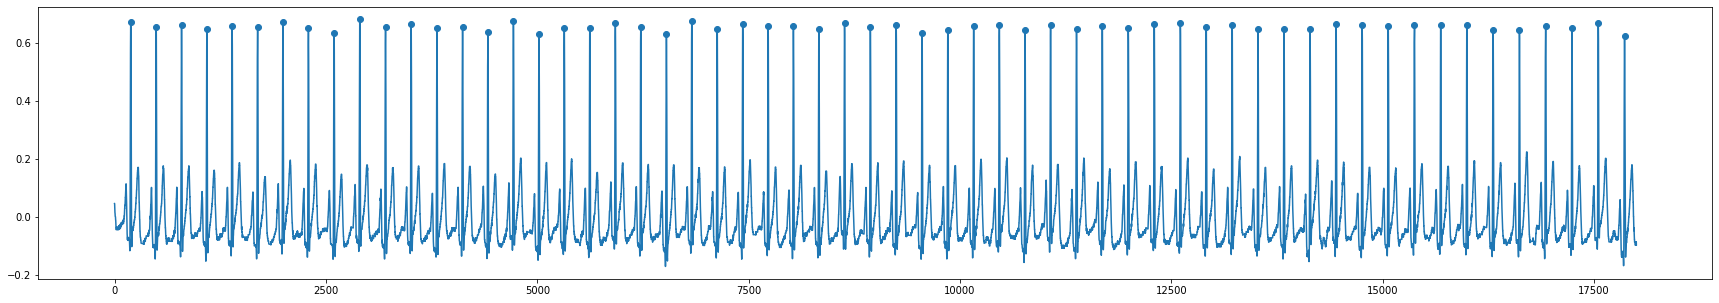

caseid 584


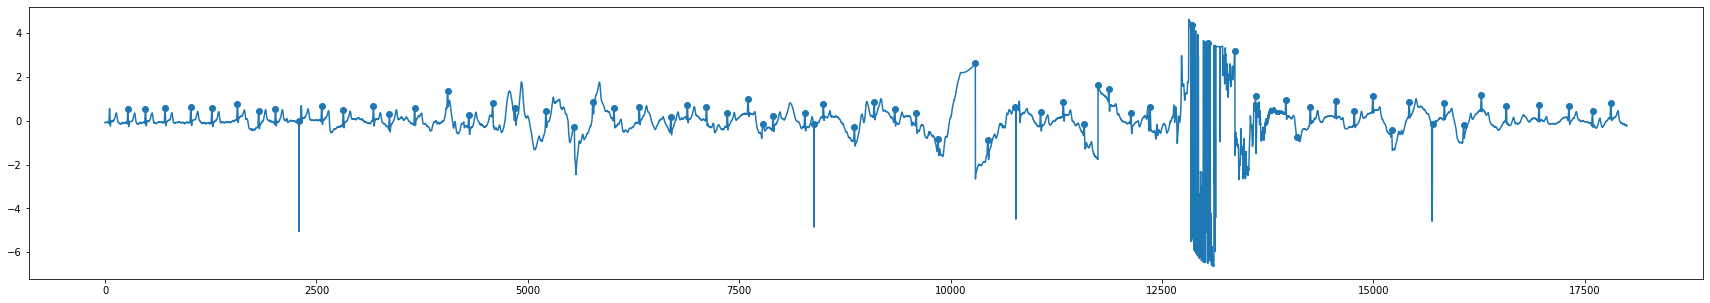

caseid 3417


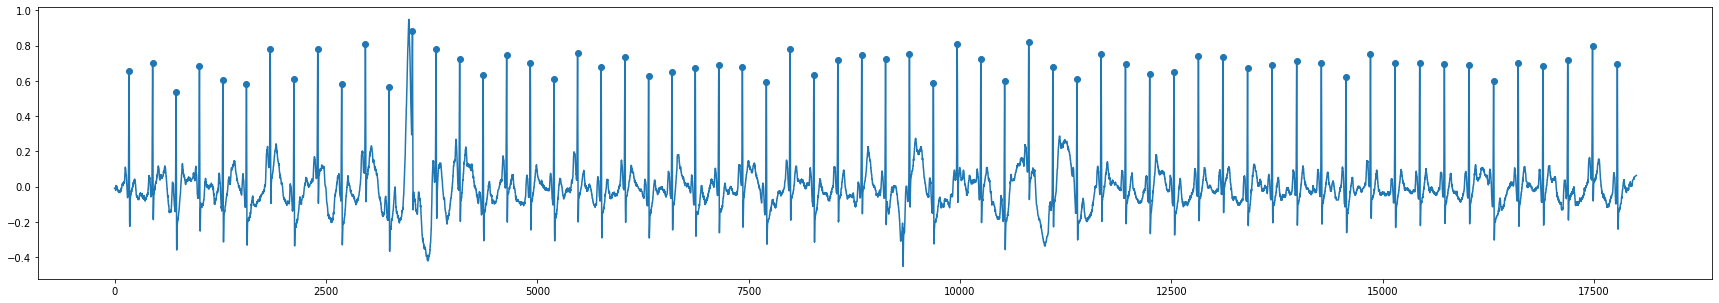

caseid 4503


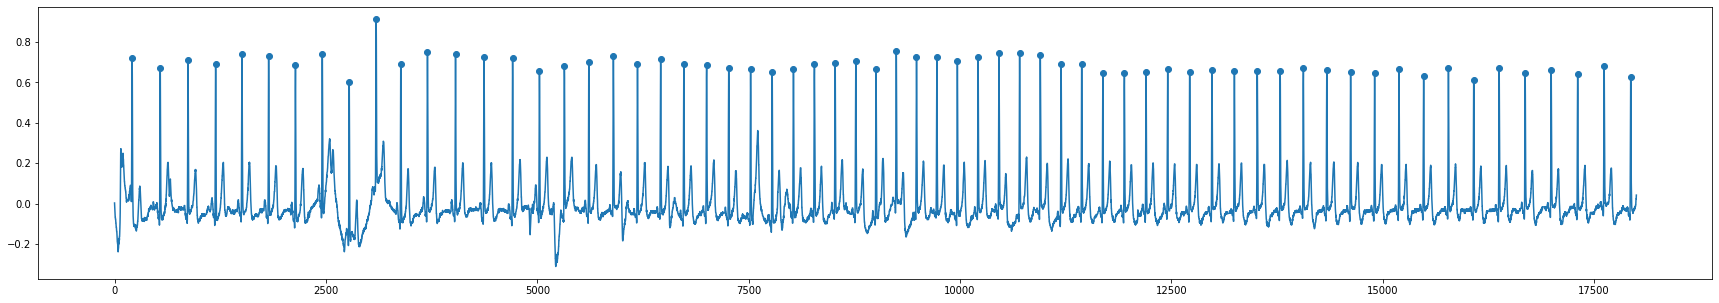

caseid 2419


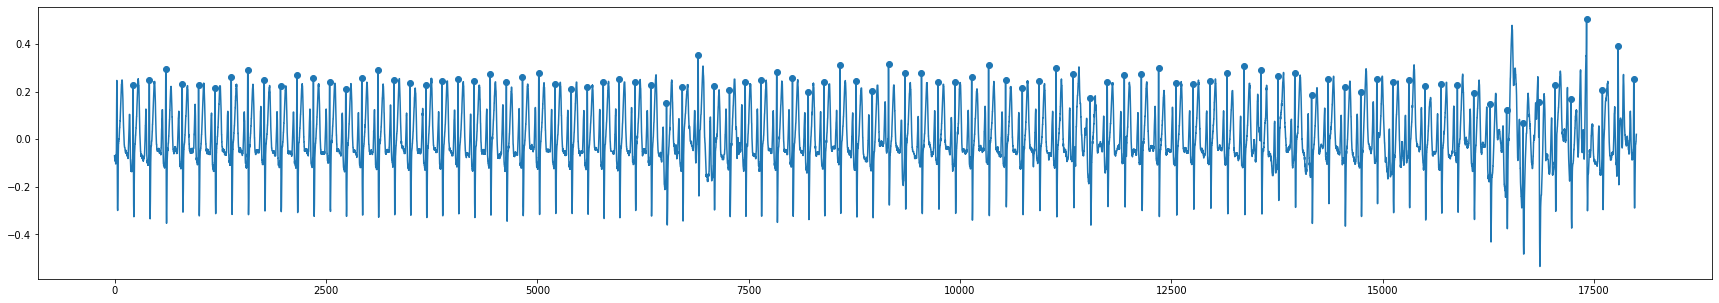

caseid 6278


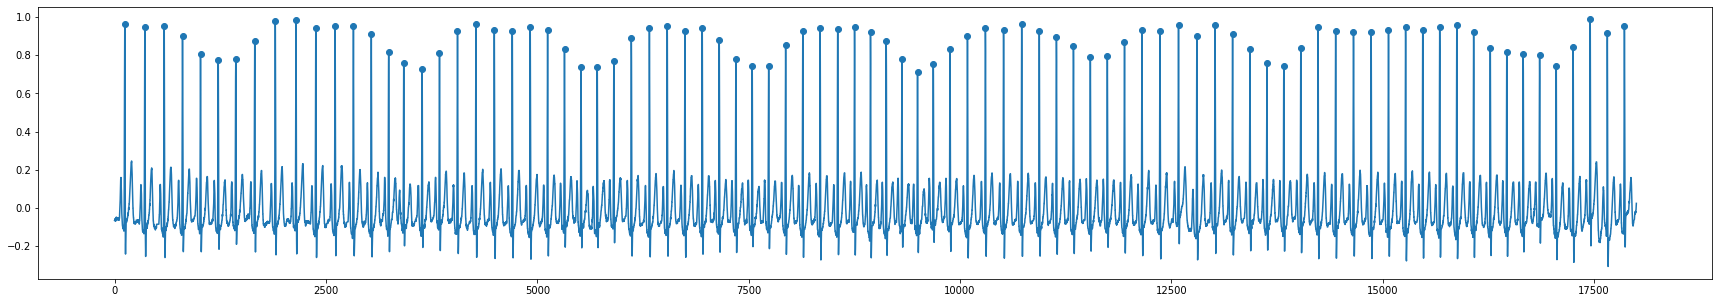

caseid 6128


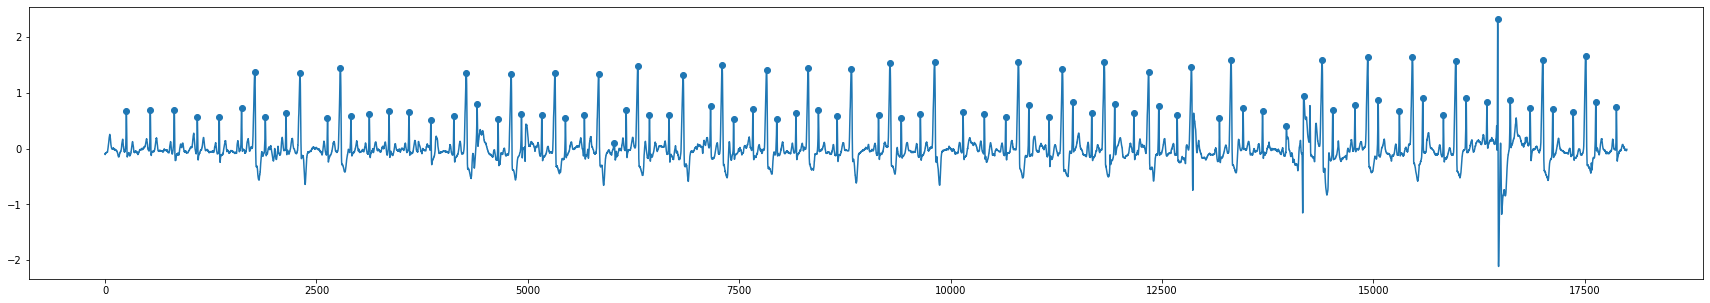

caseid 1906


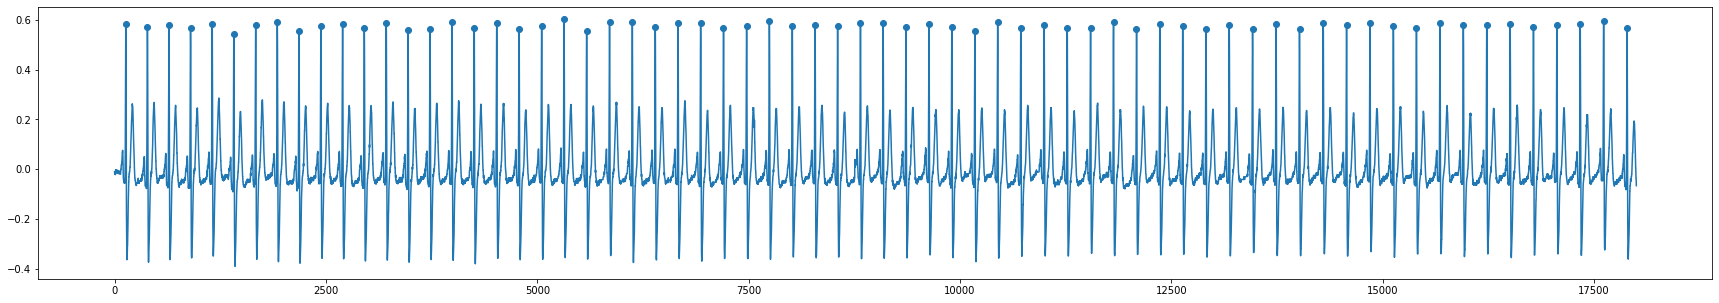

caseid 1490


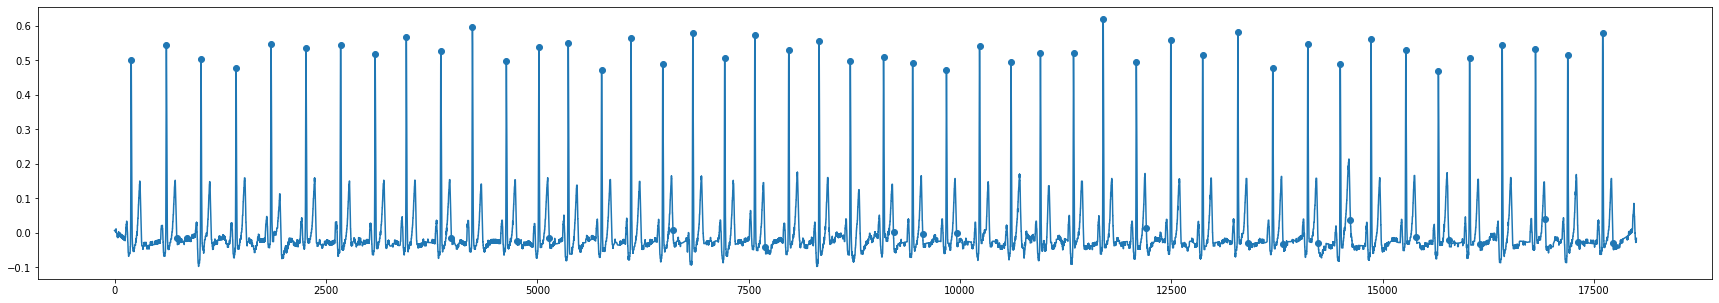

caseid 4868


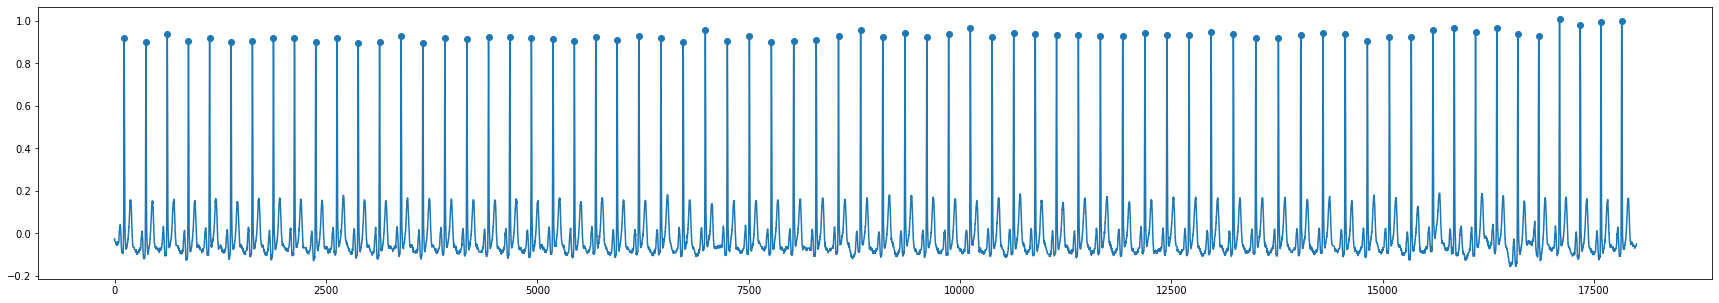

caseid 1992


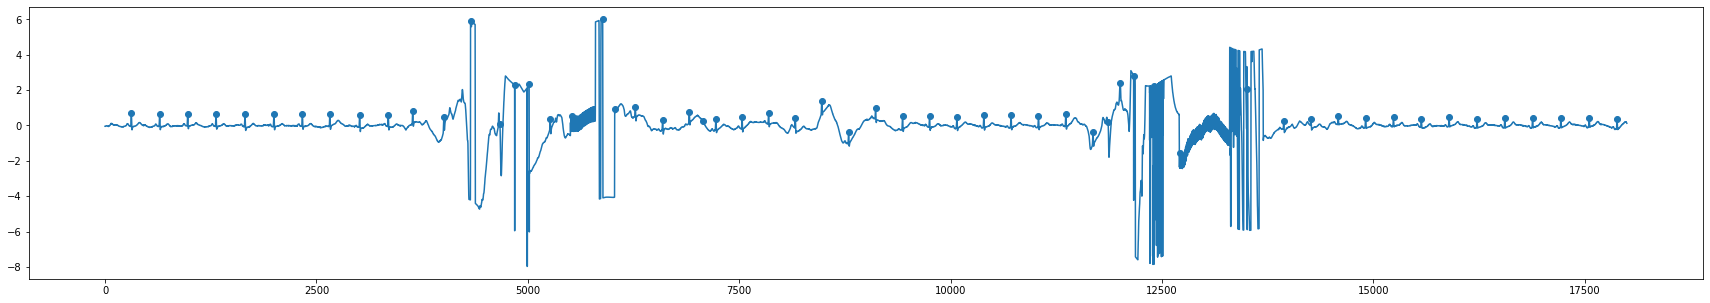

caseid 5566


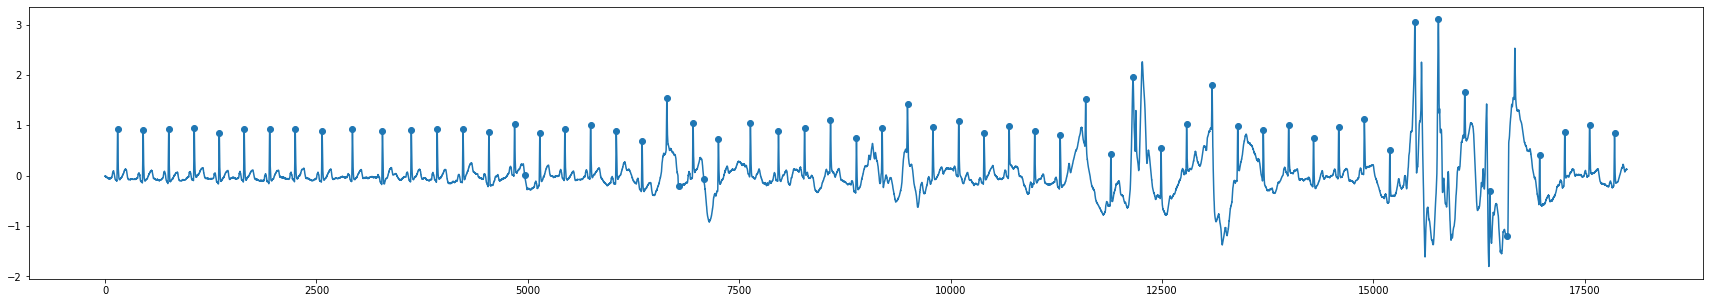

caseid 1030


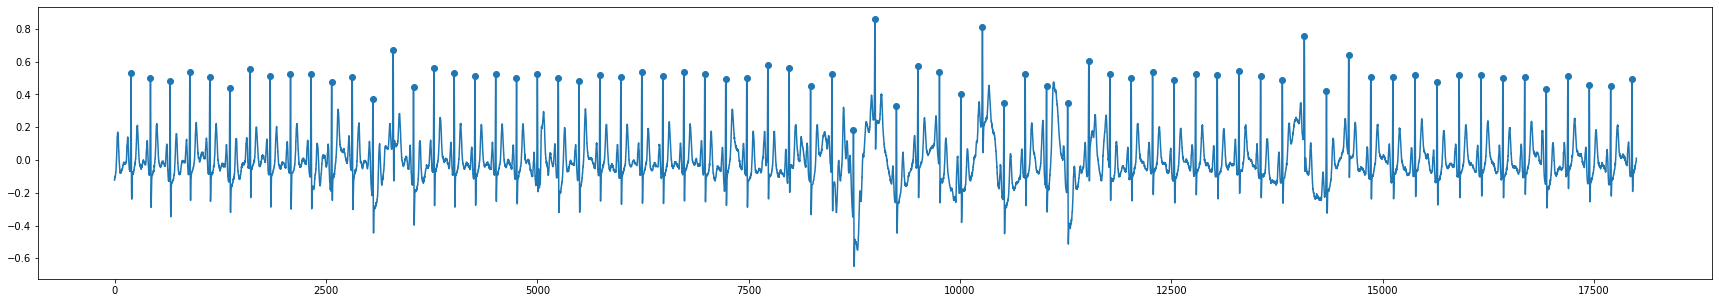

caseid 2770


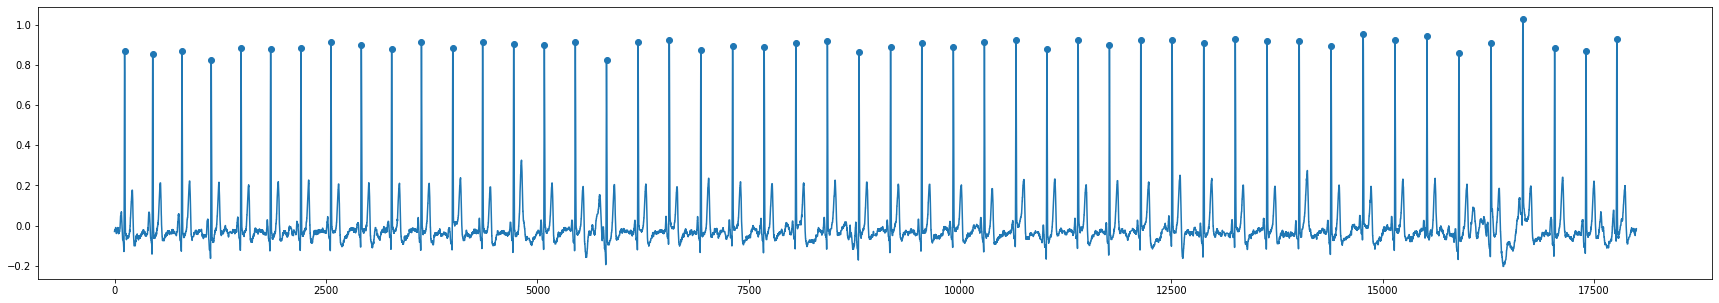

caseid 3729


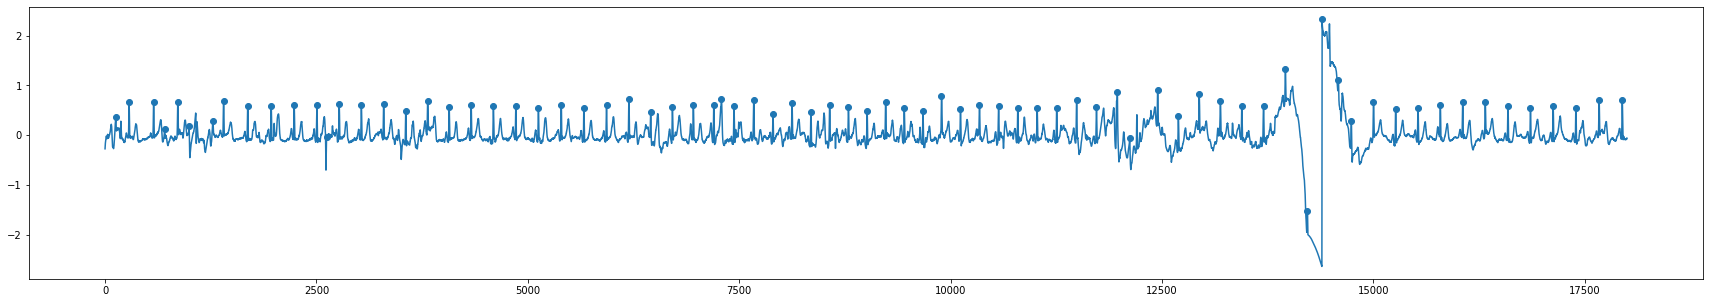

caseid 1638


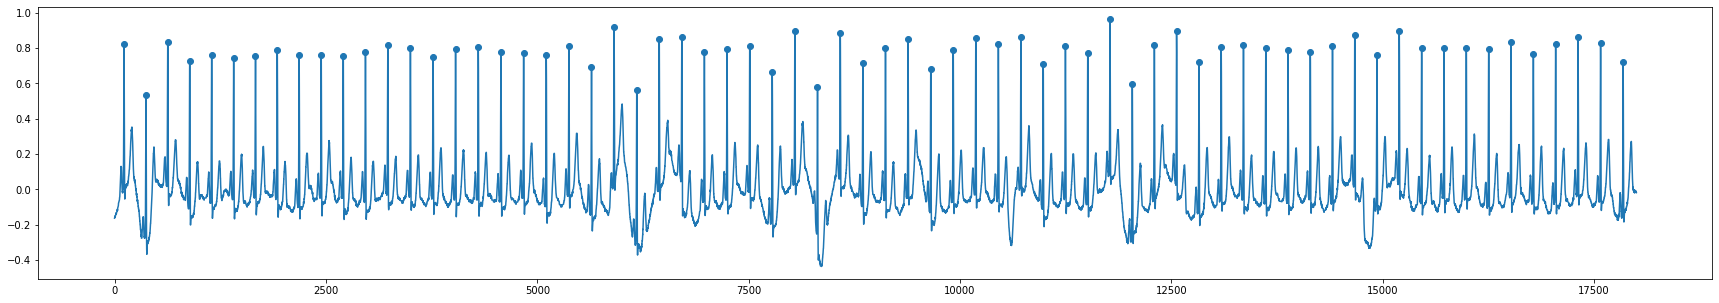

caseid 1080


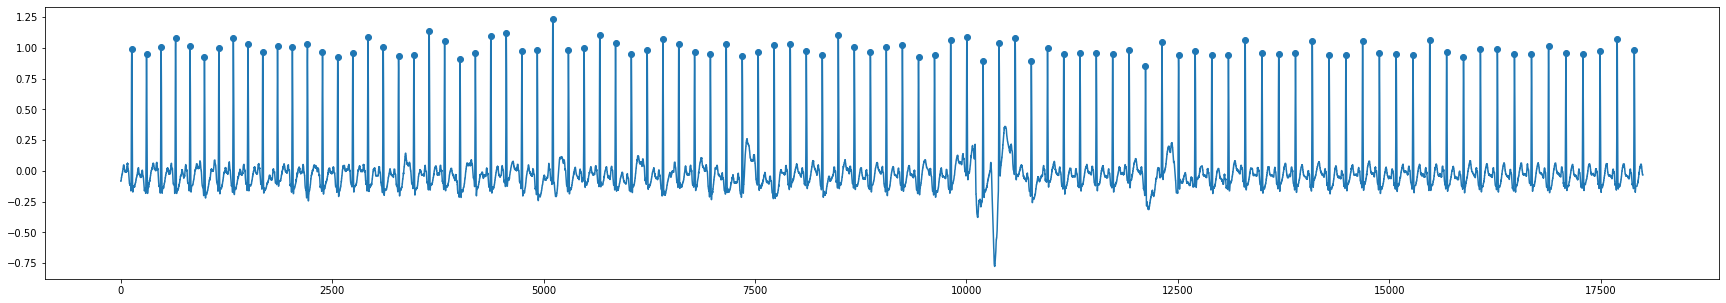

caseid 1251


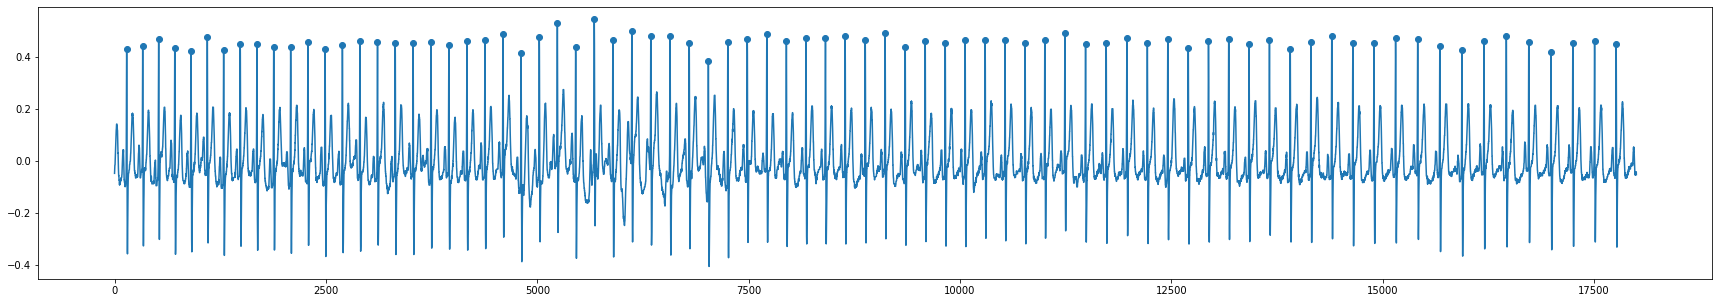

caseid 4477


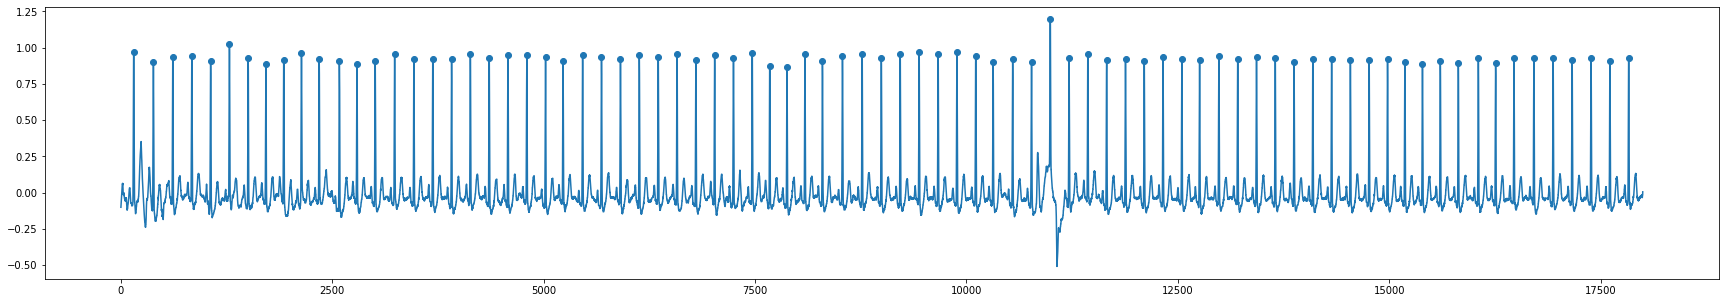

In [211]:
import os
from pyvital.pyvital import arr
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt


SRATE = 300
ECG_FILT = 'savgol'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
file_path = f'vital_to_np_pd_{SRATE}Hz'
caseids = os.listdir(file_path)


for file in caseids[20:40]:
    caseid = file[:-4]
    vals = np.load(f'{file_path}/{caseid}.npz')
    print(f'caseid {caseid}')

    seg_ppg = vals['nPPG']
    seg_ecg = vals['nECG']
    
    
    seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
    #seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=PPG_FILT, srate=SRATE)

    
    min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
    signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
    ecg_peak = info["ECG_R_Peaks"]
    
    plt.figure(figsize=(30,5))
    plt.plot(seg_ecg)
    plt.scatter(ecg_peak, seg_ecg[ecg_peak])
    plt.show()

# Data to input

## Whole code (221206)

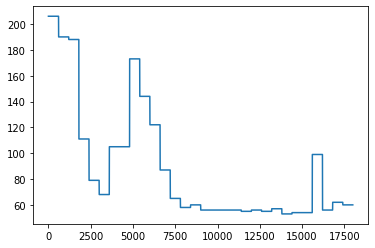

In [266]:
# caseid = '1354'
mbp = pd.DataFrame(vals['nMBP']).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
plt.plot(mbp)

In [6]:
import itertools as it
import os
import pandas as pd
import numpy as np
import random
import vitaldb
from pyvital.pyvital import arr
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import time, datetime
import neurokit2 as nk
from tqdm import tqdm

SRATE = 300
LEN_INPUT = 30
STRIDE = 10
LEN_PER_PRE = 30
LEN_PER_POST = 30


# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)

def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T
## 60초짜리 inputp에 대해 f 그려보기


def ECG_filter(seg, method, srate):
    if method == '3rd-bandpass':
        import scipy.signal
        sos = scipy.signal.butter(3, [1,47], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    # lowess랑 수학적으로 동일한데 더 빠름 - 대신 계수 체크 필요
    elif method == 'savgol':
        import scipy.signal
        return seg - scipy.signal.savgol_filter(seg, 1151, 3)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T

    else:
        print('not a valid filter')
        return seg

    
def PPG_filter(seg, method, srate):
    if method == 'bandpass':
        import scipy.signal
        sos = scipy.signal.butter(5, [1,40], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T
    
    else:
        print('not a valid filter')
        return seg
    
    
def quality_assessment(seg_ppg, seg_ecg, corr_thres):
    # peak detection
    try:
        min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
        signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
        ecg_peak = info["ECG_R_Peaks"]

    except Exception as e:
        #print('error of', e)
        return False
        
    if len(ppg_peak)==0 or len(ecg_peak)==0:
        #print('no peak')
        return False


    # segment 내의 ppg, ecg peak idx
    idx_ppg_peak = ppg_peak
    idx_ecg_peak = ecg_peak


    # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
    # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
    if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
        #print(' too less peaks', end='')
        return False
    

    # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1 (noise면 True)
    bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
    bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


    #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
    for k in range(len(bool_noise_ppg)):
        if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
            bool_noise_ppg[k] = True
    for k in range(len(bool_noise_ecg)):
        if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
            bool_noise_ecg[k] = True


    # 2.2 모양 이상한 noise
    # wave interval into same length(2s(200))
    len_wave = 2*SRATE
    norm_seg_ppg, norm_seg_ecg = [], []

    for k in range(len(bool_noise_ppg)):
        len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
        # peak 사이 wave를 모두 같은 길이로 변환
        norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

    for k in range(len(bool_noise_ecg)):
        len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
        # peak 사이 wave를 모두 같은 길이로 변환
        norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])

    # wave interval 사이 correlation 계산 - PPG
    corr_ppg = []
    mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
    mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
    norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    for k in range(len(bool_noise_ppg)):
        corr = np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1]
        corr_ppg.append(corr)
    noise_ppg_perc = np.mean(bool_noise_ppg | (np.array(corr_ppg) < corr_thres))


    # wave interval 사이 correlation 계산 - ECG   
    corr_ecg = []
    mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
    mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
    norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    for k in range(len(bool_noise_ecg)):
        corr = np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1]
        corr_ecg.append(corr)
    noise_ecg_perc = np.mean(bool_noise_ecg | (np.array(corr_ecg) < corr_thres))                          

    
    # segment의 noise 비율 정보를 return
    return [noise_ppg_perc, noise_ecg_perc]


def preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES):
    ### Preprocess of input : Denosing -> Quality Assessment
    ### stores the result of preprocess in dataframe
    # path for cache
    if not os.path.exists('./cache'):
        os.mkdir('./cache')     
    if not os.path.exists('./cache/preprocess'):
        os.mkdir('./cache/preprocess')

    hyper_path = f'SRATE{SRATE}_LEN{LEN_INPUT}-PRE{LEN_PER_PRE}-POST{LEN_PER_POST}_STR{STRIDE}_PPG-{PPG_FILT}_ECG-{ECG_FILT}'
    input_path = f"../DL_model/dataset/PD_{hyper_path}/"
    if not os.path.exists('../DL_model/dataset'):
        os.mkdir('../DL_model/dataset')
    if not os.path.exists(input_path[:-1]):
        os.mkdir(input_path[:-1])  
        

    # dataframe to save preprocessing info
    n_aug = int((LEN_PER_PRE-LEN_INPUT)/STRIDE) + 1
    column_list = ['caseid'] + [f'{i+1}' for i in np.arange(n_aug)] + ['age', 'gender']
    df_preprocess = pd.DataFrame(columns = column_list)

    # df_preprocess에 demographs(age, gender) 추가
    df_demograph = pd.read_csv("https://api.vitaldb.net/cases")

    
    
    # set variables
    caseids = os.listdir(file_path)
    f_num = 0
    initial, interval = f_num, len(caseids)
    
    # variables
    non_lis, low_mbp = [], []
    x, x_rftn, y, c = [], [], [], []
    age, gender, y_mbp = [], [], []
    nan_hr, nan_mbp, nan_rftn = 0, 0, 0

    start = time.time()
    pbar = tqdm(caseids[initial:initial+interval])
    for caseid in pbar:
        caseid = caseid[:-4]   # '123.npz' -> '123'
        f_num += 1

        # vital data 불러오기
        try:
            vals = np.load(f'{file_path}/{caseid}.npz')
            
        except Exception as e:
            continue

        
        # baseline 혈압이 낮은 경우(<65mmHg)는 제외: ephedrine, phenylephrine 투여 가능성
        nmbp = pd.DataFrame(vals['nMBP']).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        if len(nmbp) == 0:
            nan_mbp = nan_mbp + 1
            continue
        if nmbp[-1] < 65:
            low_mbp.append(caseid)
            continue
            

        ### before intubation event (-120 ~ -60sec) preprocessing  
        #n_aug = int((LEN_PER_PRE-LEN_INPUT)/STRIDE) + 1
        segs_ppg = vals['nPPG'][-LEN_PER_PRE*SRATE:]
        segs_ecg = vals['nECG'][-LEN_PER_PRE*SRATE:]
        for i in range(n_aug):
            # vital data
            seg_ppg = segs_ppg[i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
            seg_ecg = segs_ecg[i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
            
            if len(seg_ppg) == 0 or len(seg_ecg) == 0:
                #print('not valid ecg, ppg', end='...')
                continue

            seg_ppg = [np.nan if ele <=-200 else ele for ele in seg_ppg]
            seg_ecg = [np.nan if ele <=-4 else ele for ele in seg_ecg]

            #dataframe에 새로운 행 만들기
            df_preprocess.loc[f_num-1,'caseid'] = caseid
            
            row_demo = df_demograph[df_demograph['caseid']==int(caseid)]
            df_preprocess.loc[f_num-1, 'age'] = row_demo['age'].values[0]
            df_preprocess.loc[f_num-1, 'gender'] = row_demo['sex'].values[0]

            
            ## 1. 결측치 제거 ##
            nan_ppg_perc = np.mean(np.isnan(seg_ppg))
            nan_ecg_perc = np.mean(np.isnan(seg_ecg))

            # segment의 결측치 비율 정보
            nan_info = [nan_ppg_perc, nan_ecg_perc]

            # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
            if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
                #print(' too much missing data', end='...')
                df_preprocess.loc[f_num-1,f'{i+1}'] = (False, nan_info, [-1, -1])
                continue


            ## 2. Denosing ##
            # ECG : 1-40Hz bandpass filter / PPG : loess filter
            seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
            seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=PPG_FILT, srate=SRATE)


            ## 3. Quality Assessment ## 
            # segment의 noise 비율 정보
            noise_info = quality_assessment(seg_ppg, seg_ecg, CORR_THRES) 
            
            # Fail the preprocess
            if not noise_info:
                df_preprocess.loc[f_num-1,f'{i+1}'] = (False, nan_info, [-2, -2])
                continue


            # segment를 input으로 써도 되는지
            bool_pass = [True if noise_info[0] < 0.1 and noise_info[1] < 0.1 else False]


            # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
            df_preprocess.loc[f_num-1,f'{i+1}'] = (bool_pass[0], nan_info, noise_info)
            #print(f'preprocessing done...{bool_pass[0]}', end='')
            
            
            if bool_pass[0]:
                rftn = vals['nRFTN'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
                rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                rftn = rftn / 8
                if np.mean(np.isnan(rftn)) != 0:
                    nan_rftn = nan_rftn + 1
                    continue

                # z-score normalization
                ppg_input = stats.zscore(seg_ppg)
                ecg_input = stats.zscore(seg_ecg)

                
                hr = vals['HR'][:LEN_PER_POST*SRATE][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
                nhr = vals['nHR'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
                if np.nanmean(hr) == 0 or np.nanmean(nhr) == 0:
                    #print(f'abnormal HR value of caseid {caseid}') 
                    nan_hr = nan_hr + 1
                    continue
                del_hr = np.nanmean(hr) / np.nanmean(nhr) - 1
                
                if np.isnan(del_hr):
                    #print(f'  del_hr of caseid {caseid} value is nan')
                    nan_hr = nan_hr + 1
                    continue

                # MBP
                del_mbp = np.nanmean(vals['MBP'][:LEN_PER_POST*SRATE][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) / np.nanmean(vals['nMBP'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) - 1
                if np.isnan(del_mbp):
                    nan_mbp = nan_mbp + 1
                y_mbp.append(del_mbp)
                
                age.append(int(row_demo['age'].values[0]))
                if row_demo['sex'].values[0]=='F':
                    gender.append(1)
                else:
                    gender.append(0)
                x.append([ppg_input, ecg_input])
                x_rftn.append(rftn)
                y.append(del_hr)
                c.append(caseid)

    print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')


    df_preprocess.reset_index(drop=True, inplace=True)    
    pickle.dump(df_preprocess, open(f'cache/preprocess/df_preprocess_{hyper_path}', 'wb'))
    print('dumping success')
    
    # dataset
    x = np.array(x, np.float32)
    x_rftn = np.array(x_rftn, np.float32)
    y = np.array(y, np.float32)
    y_mbp = np.array(y_mbp)
    c = np.array(c)
    age = np.array(age, int)
    gender = np.array(gender, int)

    # 알맞게 input 변환
    x = np.transpose(x, [0,2,1])

    print('after concatenate + transpose')
    print('x shape:', x.shape)
    print('rftn shape:', x_rftn.shape)
    print('y shape:', y.shape)
    print('caseid num: ', len(c))
    print(f'input path: {input_path}\n')
    print(datetime.datetime.now())


    # train, test set
    caseids = list(np.unique(c))
    if len(caseids) != len(c):
        print('overlapped caseid exists')
    random.shuffle(caseids)

    ntest = max(1, int(len(caseids) * 0.1))
    ntrain = len(caseids) - ntest

    caseid_train = caseids[:ntrain]
    caseid_test = caseids[ntrain:]

    print('전체 caseid 수: {}'.format(len(caseids)))
    print('train caseid 수: {}, test caseid 수: {}'.format(len(caseid_train), len(caseid_test)))

    pickle.dump(caseid_train, open(f'../DL_model/pd/caseid_train_{hyper_path}','wb'))
    pickle.dump(caseid_test, open(f'../DL_model/pd/caseid_test_{hyper_path}','wb'))

    train_mask = np.isin(c, caseid_train)
    test_mask = np.isin(c, caseid_test)

    x_train = x[train_mask]
    x_test = x[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    mbp_train = y_mbp[train_mask]
    mbp_test = y_mbp[test_mask]
    rftn_train = x_rftn[train_mask]
    rftn_test = x_rftn[test_mask]
    c_train = c[train_mask]
    c_test = c[test_mask]

    age_train = age[train_mask]
    age_test = age[test_mask]
    gender_train = gender[train_mask]
    gender_test = gender[test_mask]


    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train.npz', x_train)
    np.savez_compressed(input_path+'x_test.npz', x_test)
    np.savez_compressed(input_path+'rftn_train.npz', rftn_train)
    np.savez_compressed(input_path+'rftn_test.npz', rftn_test)
    np.savez_compressed(input_path+'y_train.npz', y_train)
    np.savez_compressed(input_path+'y_test.npz', y_test)
    np.savez_compressed(input_path+'mbp_train.npz', mbp_train)
    np.savez_compressed(input_path+'mbp_test.npz', mbp_test)
    np.savez_compressed(input_path+'c_train.npz', c_train)
    np.savez_compressed(input_path+'c_test.npz', c_test)

    np.savez_compressed(input_path+'age_train.npz', age_train)
    np.savez_compressed(input_path+'age_test.npz', age_test)
    np.savez_compressed(input_path+'gender_train.npz', gender_train)
    np.savez_compressed(input_path+'gender_test.npz', gender_test)

    print('done', flush=True)
    print('\nsize of training set:', len(x_train))
    print('size of test set:', len(x_test)) 
    print(f'num of hr value nan : {nan_hr}')
    print(f'num of mbp value nan : {nan_mbp}')
    print(f'num of rftn value nan : {nan_rftn}')
    print(f'num of low baseline bp : {len(low_mbp)}')

    print(datetime.datetime.now())
    print(f'total elapsed time for preprocess: {time.time() - start:.2f}s\n')


    # 전처리 통과 비율 출력
    nl_pass, l_pass = [], []
    for idx, row in df_preprocess.iterrows():
        for i in range(n_aug):
            nl_pass.append(row[f'{i+1}'][0])
        #l_pass.append(row['2'][0])

    print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%') #, intubation 직후 {np.mean(l_pass)*100:.2f}%')
    print(datetime.datetime.now())

In [ ]:
SRATE = 300
ECG_FILT = '3rd-bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9 # cutoff
LEN_INPUT = 30 # length of the input
STRIDE = 1
LEN_PER_PRE = 30 # before intubation
LEN_PER_POST = 30

file_path = f'vital_to_np_pd_{SRATE}Hz'

preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES)

  1%|          | 18/2687 [00:11<29:43,  1.50it/s]/tmp/ipykernel_596505/1600099583.py:304: RuntimeWarning: Mean of empty slice
  del_mbp = np.nanmean(vals['MBP'][:LEN_PER_POST*SRATE][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) / np.nanmean(vals['nMBP'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) - 1
 12%|█▏        | 331/2687 [03:29<19:39,  2.00it/s]

In [ ]:
SRATE = 300
ECG_FILT = 'savgol'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
LEN_INPUT = 30
STRIDE = 1
LEN_PER_PRE = 30
LEN_PER_POST = 30

file_path = f'vital_to_np_pd_{SRATE}Hz'

preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES)

In [ ]:
SRATE = 300
ECG_FILT = '3rd-bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
LEN_INPUT = 10
STRIDE = 5
LEN_PER_PRE = 30
LEN_PER_POST = 30

file_path = f'vital_to_np_pd_{SRATE}Hz'

preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES)

In [12]:
SRATE = 300
ECG_FILT = '3rd-bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
LEN_INPUT = 60
STRIDE = 1
LEN_PER_PRE = 60
LEN_PER_POST = 60

file_path = f'vital_to_np_pd_{SRATE}Hz'

preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES)

  4%|▍         | 106/2687 [03:05<1:23:55,  1.95s/it]/tmp/ipykernel_596505/1600099583.py:304: RuntimeWarning: Mean of empty slice
  del_mbp = np.nanmean(vals['MBP'][:LEN_PER_POST*SRATE][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) / np.nanmean(vals['nMBP'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) - 1
 50%|█████     | 1351/2687 [36:50<33:38,  1.51s/it] /tmp/ipykernel_596505/1600099583.py:292: RuntimeWarning: Mean of empty slice
  if np.nanmean(hr) == 0 or np.nanmean(nhr) == 0:
/tmp/ipykernel_596505/1600099583.py:296: RuntimeWarning: Mean of empty slice
  del_hr = np.nanmean(hr) / np.nanmean(nhr) - 1
100%|██████████| 2687/2687 [1:12:54<00:00,  1.63s/it]


dumping cache of df_preprocess 2687/2687...dumping success
after concatenate + transpose
x shape: (995, 18000, 2)
rftn shape: (995, 18000)
y shape: (995,)
caseid num:  995
input path: ../DL_model/dataset/PD_SRATE300_LEN60-PRE60-POST60_STR1_PPG-lowess_ECG-3rd-bandpass/

2022-12-08 12:01:14.321096
전체 caseid 수: 995
train caseid 수: 896, test caseid 수: 99
saving...

done

size of training set: 896
size of test set: 99
num of hr value nan : 3
num of mbp value nan : 91
num of rftn value nan : 3
num of low baseline bp : 405
2022-12-08 12:01:21.970130
total elapsed time for preprocess: 4381.88s

전처리 성공 비율 : intubation 직전 44.41%
2022-12-08 12:01:22.098055


## Manual

In [302]:
if not os.path.exists('./cache'):
    os.mkdir('./cache')     
if not os.path.exists('./cache/preprocess'):
    os.mkdir('./cache/preprocess')

hyper_path = f'SRATE{SRATE}_LEN{LEN_INPUT}-PRE{LEN_PER_PRE}-POST{LEN_PER_POST}_STR{STRIDE}_PPG-{PPG_FILT}_ECG-{ECG_FILT}'
input_path = f"../DL_model/dataset/PD_{hyper_path}/"
if not os.path.exists('../DL_model/dataset'):
    os.mkdir('../DL_model/dataset')
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])  


# dataframe to save preprocessing info
n_aug = int((LEN_PER_PRE-LEN_INPUT)/STRIDE) + 1
column_list = ['caseid'] + [f'{i+1}' for i in np.arange(n_aug)] + ['age', 'gender']
df_preprocess = pd.DataFrame(columns = column_list)

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")



# set variables
caseids = os.listdir(file_path)
f_num = 0
initial, interval = f_num, len(caseids)

# variables
non_lis = []
x, x_rftn, y, c = [], [], [], []
age, gender, y_mbp = [], [], []
nan_hr = 0

start = time.time()
pbar = tqdm(caseids[initial:initial+interval])
for caseid in pbar:
    caseid = caseid[:-4]   # '123.npz' -> '123'
    f_num += 1
    #print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기
    try:
        vals = np.load(f'{file_path}/{caseid}.npz')

    except Exception as e:
        continue


    ### before intubation event (-120 ~ -60sec) preprocessing  
    #n_aug = int((LEN_PER_PRE-LEN_INPUT)/STRIDE) + 1
    segs_ppg = vals['nPPG'][-LEN_PER_PRE*SRATE:]
    segs_ecg = vals['nECG'][-LEN_PER_PRE*SRATE:]
    for i in range(n_aug):
        # vital data
        seg_ppg = segs_ppg[i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
        seg_ecg = segs_ecg[i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]

        if len(seg_ppg) == 0 or len(seg_ecg) == 0:
            #print('not valid ecg, ppg', end='...')
            continue

        seg_ppg = [np.nan if ele <=-200 else ele for ele in seg_ppg]
        seg_ecg = [np.nan if ele <=-4 else ele for ele in seg_ecg]

        #dataframe에 새로운 행 만들기
        df_preprocess.loc[f_num-1,'caseid'] = caseid

        row_demo = df_demograph[df_demograph['caseid']==int(caseid)]
        df_preprocess.loc[f_num-1, 'age'] = row_demo['age'].values[0]
        df_preprocess.loc[f_num-1, 'gender'] = row_demo['sex'].values[0]


        ## 1. 결측치 제거 ##
        nan_ppg_perc = np.mean(np.isnan(seg_ppg))
        nan_ecg_perc = np.mean(np.isnan(seg_ecg))

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
            #print(' too much missing data', end='...')
            df_preprocess.loc[f_num-1,f'{i+1}'] = (False, nan_info, [-1, -1])
            continue


        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
        seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=PPG_FILT, srate=SRATE)


        ## 3. Quality Assessment ## 
        # segment의 noise 비율 정보
        noise_info = quality_assessment(seg_ppg, seg_ecg, CORR_THRES) 

        # Fail the preprocess
        if not noise_info:
            df_preprocess.loc[f_num-1,f'{i+1}'] = (False, nan_info, [-2, -2])
            continue


        # segment를 input으로 써도 되는지
        bool_pass = [True if noise_info[0] < 0.1 and noise_info[1] < 0.1 else False]


        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        df_preprocess.loc[f_num-1,f'{i+1}'] = (bool_pass[0], nan_info, noise_info)
        #print(f'preprocessing done...{bool_pass[0]}', end='')


        if bool_pass[0]:
            rftn = vals['nRFTN']
            rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

            # z-score normalization
            ppg_input = stats.zscore(seg_ppg)
            ecg_input = stats.zscore(seg_ecg)


            if np.nanmean(vals['HR'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) == 0 or np.nanmean(vals['nHR'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) == 0:
                #print(f'abnormal HR value of caseid {caseid}') 
                continue
            del_hr = np.nanmean(vals['HR'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) / np.nanmean(vals['nHR'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) - 1

            if np.isnan(del_hr):
                #print(f'  del_hr of caseid {caseid} value is nan')
                nan_hr = nan_hr + 1
                continue

            # MBP
            del_mbp = np.nanmean(vals['MBP'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) / np.nanmean(vals['nMBP'][-LEN_PER_POST*SRATE:][i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]) - 1
            y_mbp.append(del_mbp)

            age.append(int(row_demo['age'].values[0]))
            if row_demo['sex'].values[0]=='F':
                gender.append(1)
            else:
                gender.append(0)
            x.append([ppg_input, ecg_input])
            x_rftn.append(rftn)
            y.append(del_hr)
            c.append(caseid)

print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')


df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open(f'cache/preprocess/df_preprocess_{hyper_path}', 'wb'))
print('dumping success')

# dataset
x = np.array(x, np.float32)
x_rftn = np.array(x_rftn, np.float32)
y = np.array(y, np.float32)
y_mbp = np.array(y_mbp)
c = np.array(c)
age = np.array(age, int)
gender = np.array(gender, int)

# 알맞게 input 변환
x = np.transpose(x, [0,2,1])

print('after concatenate + transpose')
print('x shape:', x.shape)
print('rftn shape:', x_rftn.shape)
print('y shape:', y.shape)
print('caseid num: ', len(c))
print(f'input path: {input_path}\n')
print(datetime.datetime.now())


# train, test set
caseids = list(np.unique(c))
if len(caseids) != len(c):
    print('STRIDEping caseid exists')
random.shuffle(caseids)

ntest = max(1, int(len(caseids) * 0.1))
ntrain = len(caseids) - ntest

caseid_train = caseids[:ntrain]
caseid_test = caseids[ntrain:]

print('전체 caseid 수: {}'.format(len(caseids)))
print('train caseid 수: {}, test caseid 수: {}'.format(len(caseid_train), len(caseid_test)))

pickle.dump(caseid_train, open(f'../DL_model/pd/caseid_train_{hyper_path}','wb'))
pickle.dump(caseid_test, open(f'../DL_model/pd/caseid_test_{hyper_path}','wb'))

train_mask = np.isin(c, caseid_train)
test_mask = np.isin(c, caseid_test)

x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
mbp_train = y_mbp[train_mask]
mbp_test = y_mbp[test_mask]
rftn_train = x_rftn[train_mask]
rftn_test = x_rftn[test_mask]
c_train = c[train_mask]
c_test = c[test_mask]

age_train = age[train_mask]
age_test = age[test_mask]
gender_train = gender[train_mask]
gender_test = gender[test_mask]


# 저장하기
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'rftn_train.npz', rftn_train)
np.savez_compressed(input_path+'rftn_test.npz', rftn_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
np.savez_compressed(input_path+'mbp_train.npz', mbp_train)
np.savez_compressed(input_path+'mbp_test.npz', mbp_test)
np.savez_compressed(input_path+'c_train.npz', c_train)
np.savez_compressed(input_path+'c_test.npz', c_test)

np.savez_compressed(input_path+'age_train.npz', age_train)
np.savez_compressed(input_path+'age_test.npz', age_test)
np.savez_compressed(input_path+'gender_train.npz', gender_train)
np.savez_compressed(input_path+'gender_test.npz', gender_test)

print('done', flush=True)
print('\nsize of training set:', len(x_train))
print('size of test set:', len(x_test)) 
print(f'num of hr value nan : {nan_hr}')

print(datetime.datetime.now())
print(f'total elapsed time for preprocess: {time.time() - start:.2f}s\n')


# 전처리 통과 비율 출력
nl_pass, l_pass = [], []
for idx, row in df_preprocess.iterrows():
    nl_pass.append(row['1'][0])
    #l_pass.append(row['2'][0])

print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%') #, intubation 직후 {np.mean(l_pass)*100:.2f}%')
print(datetime.datetime.now())

  1%|          | 18/2687 [00:23<46:30,  1.05s/it] /tmp/ipykernel_3764291/114188205.py:134: RuntimeWarning: Mean of empty slice
  del_mbp = np.nanmean(vals['MBP'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) / np.nanmean(vals['nMBP'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) - 1
  1%|          | 30/2687 [00:36<47:51,  1.08s/it]/tmp/ipykernel_3764291/114188205.py:123: RuntimeWarning: Mean of empty slice
  if np.nanmean(vals['HR'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) == 0 or np.nanmean(vals['nHR'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) == 0:
/tmp/ipykernel_3764291/114188205.py:126: RuntimeWarning: Mean of empty slice
  del_hr = np.nanmean(vals['HR'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) / np.nanmean(vals['nHR'][-LEN_PER_POST*SRATE:][i*OVERLAP*SRATE:i*OVERLAP*SRATE+LEN_INPUT*SRATE]) - 1
100%|██████████| 2687/2687 [50:39<00:00,  1.13s


dumping cache of df_preprocess 2687/2687...dumping success
after concatenate + transpose
x shape: (7179, 3000, 2)
rftn shape: (7179, 18000)
y shape: (7179,)
caseid num:  7179
input path: ../DL_model/dataset/PD_SRATE300_LEN10-PRE30-POST30_STR5_PPG-lowess_ECG-3rd-bandpass/

2022-12-07 22:01:18.748253
overlapping caseid exists
전체 caseid 수: 1997
train caseid 수: 1798, test caseid 수: 199
saving...done

size of training set: 6460
size of test set: 719
num of hr value nan : 63
2022-12-07 22:01:31.462154
total elapsed time for preprocess: 3053.74s

전처리 성공 비율 : intubation 직전 55.47%
2022-12-07 22:01:31.606822


In [ ]:
SRATE = 300
ECG_FILT = '3rd-bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
LEN_INPUT = 10
STRIDE = 5
LEN_PER_PRE = 30
LEN_PER_POST = 30

file_path = f'vital_to_np_pd_{SRATE}Hz'

start = time.time()
preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES)
print(f'total passed time : {time.time() - start:.2f}s')

In [229]:
### Preprocess of input : Denosing -> Quality Assessment
### stores the result of preprocess in dataframe
# path for cache
if not os.path.exists('./cache'):
    os.mkdir('./cache')     
if not os.path.exists('./cache/preprocess'):
    os.mkdir('./cache/preprocess')

input_path = f"../DL_model/dataset/PD_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}/"
if not os.path.exists('../DL_model/dataset'):
    os.mkdir('../DL_model/dataset')
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])  


# dataframe to save preprocessing info
column_list = ['caseid'] + ['1'] + ['age', 'gender']
df_preprocess = pd.DataFrame(columns = column_list)

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")



# set variables
caseids = os.listdir(file_path)
f_num = 0
initial, interval = f_num, len(caseids)

# variables
non_lis = []
x, x_rftn, y, c = [], [], [], []
age, gender = [], []
nan_hr = 0

start = time.time()
pbar = tqdm(caseids[initial:initial+interval])
for caseid in pbar:
    caseid = caseid[:-4]   # '123.npz' -> '123'
    f_num += 1
    #print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기
    try:
        vals = np.load(f'{file_path}/{caseid}.npz')

    except Exception as e:
        continue


    ### before intubation event (-120 ~ -60sec) preprocessing  
    for i in range(1):
        # vital data
        seg_ppg = vals['nPPG']
        seg_ecg = vals['nECG']

        if len(seg_ppg) == 0 or len(seg_ecg) == 0:
            #print('not valid ecg, ppg', end='...')
            continue

        seg_ppg = [np.nan if ele <=-200 else ele for ele in seg_ppg]
        seg_ecg = [np.nan if ele <=-4 else ele for ele in seg_ecg]

        #dataframe에 새로운 행 만들기
        df_preprocess.loc[f_num-1,'caseid'] = caseid

        row_demo = df_demograph[df_demograph['caseid']==int(caseid)]
        df_preprocess.loc[f_num-1, 'age'] = row_demo['age'].values[0]
        df_preprocess.loc[f_num-1, 'gender'] = row_demo['sex'].values[0]


        ## 1. 결측치 제거 ##
        nan_ppg_perc = np.mean(np.isnan(seg_ppg))
        nan_ecg_perc = np.mean(np.isnan(seg_ecg))

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
            #print(' too much missing data', end='...')
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-1, -1])
            continue


        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
        seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=PPG_FILT, srate=SRATE)


        ## 3. Quality Assessment ## 
        # segment의 noise 비율 정보
        noise_info = quality_assessment(seg_ppg, seg_ecg, CORR_THRES) 

        # Fail the preprocess
        if not noise_info:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
            continue


        # segment를 input으로 써도 되는지
        bool_pass = [True if noise_info[0] < 0.1 and noise_info[1] < 0.1 else False]


        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        #arry = np.empty(1, dtype=object)
        #arry[0] = [bool_pass[0], nan_info, noise_info]
        #df_preprocess.loc[f_num-1,'1'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}
        df_preprocess.loc[f_num-1,'1'] = (bool_pass[0], nan_info, noise_info)
        #print(f'preprocessing done...{bool_pass[0]}', end='')


        if bool_pass[0]:
            rftn = vals['nRFTN']
            rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            rftn = rftn / 8

            # z-score normalization
            ppg_input = stats.zscore(seg_ppg)
            ecg_input = stats.zscore(seg_ecg)


            if np.nanmean(vals['HR']) == 0 or np.nanmean(vals['nHR']) == 0:
                #print(f'abnormal HR value of caseid {caseid}') 
                continue
            del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1

            if np.isnan(del_hr):
                #print(f'  del_hr of caseid {caseid} value is nan')
                nan_hr = nan_hr + 1
                continue

            if np.sum(np.isnan(rftn)):
                #print(f'  nan input : caseid {caseid}')
                continue

            age.append(int(row_demo['age'].values[0]))
            if row_demo['sex'].values[0]=='F':
                gender.append(1)
            else:
                gender.append(0)
            x.append([ppg_input, ecg_input])
            x_rftn.append(rftn)
            y.append(del_hr)
            c.append(caseid)

  3%|▎         | 70/2700 [02:20<1:23:06,  1.90s/it]

 too less peaks

  3%|▎         | 76/2700 [02:32<1:22:45,  1.89s/it]

 too less peaks

  3%|▎         | 79/2700 [02:37<1:21:08,  1.86s/it]

 too less peaks

  3%|▎         | 80/2700 [02:39<1:18:18,  1.79s/it]

 too less peaks

  4%|▍         | 103/2700 [03:22<1:18:41,  1.82s/it]

 too less peaks

  4%|▍         | 114/2700 [03:41<1:13:28,  1.70s/it]

 too less peaks

  6%|▌         | 155/2700 [04:59<1:21:37,  1.92s/it]

error of index 0 is out of bounds for axis 0 with size 0


  7%|▋         | 185/2700 [05:56<1:07:04,  1.60s/it]

 too less peaks

  7%|▋         | 186/2700 [05:58<1:06:29,  1.59s/it]

 too less peaks

  8%|▊         | 229/2700 [07:21<1:19:49,  1.94s/it]

 too less peaks

  9%|▊         | 231/2700 [07:24<1:14:47,  1.82s/it]

 too less peaks

 10%|█         | 272/2700 [08:41<1:12:19,  1.79s/it]

 too less peaks

 12%|█▏        | 323/2700 [10:22<1:12:38,  1.83s/it]

 too less peaks

 13%|█▎        | 341/2700 [10:57<1:18:22,  1.99s/it]

 too less peaks

 13%|█▎        | 345/2700 [11:05<1:16:04,  1.94s/it]

 too less peaks

 14%|█▎        | 369/2700 [11:53<1:16:16,  1.96s/it]

 too less peaks

 14%|█▍        | 390/2700 [12:36<1:13:07,  1.90s/it]

error of index 0 is out of bounds for axis 0 with size 0


 18%|█▊        | 476/2700 [15:30<1:13:04,  1.97s/it]

error of index 0 is out of bounds for axis 0 with size 0


 19%|█▉        | 510/2700 [16:38<1:12:15,  1.98s/it]

error of index 0 is out of bounds for axis 0 with size 0


 20%|█▉        | 539/2700 [17:34<1:09:36,  1.93s/it]

 too less peaks

 20%|██        | 541/2700 [17:38<1:07:51,  1.89s/it]

error of index 0 is out of bounds for axis 0 with size 0


 21%|██        | 555/2700 [18:07<1:10:52,  1.98s/it]

error of index 0 is out of bounds for axis 0 with size 0


 21%|██        | 561/2700 [18:16<59:11,  1.66s/it]  

 too less peaks

 21%|██        | 573/2700 [18:41<1:08:05,  1.92s/it]

 too less peaks

 22%|██▏       | 604/2700 [19:41<1:06:26,  1.90s/it]

 too less peaks

 24%|██▎       | 636/2700 [20:43<1:04:45,  1.88s/it]

 too less peaks

 24%|██▍       | 646/2700 [21:01<52:42,  1.54s/it]  

 too less peaks

 25%|██▍       | 663/2700 [21:30<1:02:51,  1.85s/it]

error of index 0 is out of bounds for axis 0 with size 0


 25%|██▍       | 668/2700 [21:40<1:01:15,  1.81s/it]

 too less peaks

 26%|██▌       | 690/2700 [22:24<1:07:58,  2.03s/it]

 too less peaks

 26%|██▌       | 698/2700 [22:35<43:51,  1.31s/it]  

 too less peaks

 27%|██▋       | 729/2700 [23:31<1:00:36,  1.85s/it]

 too less peaks

 27%|██▋       | 730/2700 [23:33<57:50,  1.76s/it]  

 too less peaks

 27%|██▋       | 742/2700 [23:56<59:53,  1.84s/it]  

 too less peaks

 28%|██▊       | 750/2700 [24:12<1:00:22,  1.86s/it]

error of index 0 is out of bounds for axis 0 with size 0


 28%|██▊       | 754/2700 [24:20<59:30,  1.83s/it]  

 too less peaks

 28%|██▊       | 755/2700 [24:21<57:09,  1.76s/it]

 too less peaks

 32%|███▏      | 874/2700 [28:13<57:13,  1.88s/it]  

 too less peaks

 34%|███▍      | 914/2700 [29:29<54:08,  1.82s/it]  

 too less peaks

 34%|███▍      | 915/2700 [29:30<52:14,  1.76s/it]

error of index 0 is out of bounds for axis 0 with size 0


 36%|███▌      | 966/2700 [31:08<50:41,  1.75s/it]  

 too less peaks

 36%|███▌      | 970/2700 [31:16<53:35,  1.86s/it]

error of index 0 is out of bounds for axis 0 with size 0


 36%|███▌      | 971/2700 [31:17<51:27,  1.79s/it]

 too less peaks

 36%|███▌      | 973/2700 [31:21<51:57,  1.81s/it]

 too less peaks

 37%|███▋      | 987/2700 [31:48<54:03,  1.89s/it]

error of index 0 is out of bounds for axis 0 with size 0


 37%|███▋      | 1010/2700 [32:33<53:42,  1.91s/it]  

 too less peaks

 39%|███▉      | 1047/2700 [33:50<53:01,  1.92s/it]  

error of index 0 is out of bounds for axis 0 with size 0


 40%|███▉      | 1079/2700 [34:49<44:54,  1.66s/it]

 too less peaks

 41%|████      | 1111/2700 [35:52<50:50,  1.92s/it]

 too less peaks

 42%|████▏     | 1144/2700 [37:00<50:05,  1.93s/it]

 too less peaks

 44%|████▎     | 1177/2700 [38:04<47:45,  1.88s/it]

error of index 0 is out of bounds for axis 0 with size 0


 44%|████▎     | 1180/2700 [38:09<46:41,  1.84s/it]

 too less peaks

 44%|████▍     | 1200/2700 [38:49<47:06,  1.88s/it]

error of index 0 is out of bounds for axis 0 with size 0


 45%|████▌     | 1220/2700 [39:26<47:38,  1.93s/it]

error of index 0 is out of bounds for axis 0 with size 0


 45%|████▌     | 1227/2700 [39:39<45:23,  1.85s/it]

error of index 0 is out of bounds for axis 0 with size 0


 49%|████▊     | 1315/2700 [42:38<44:59,  1.95s/it]

error of index 0 is out of bounds for axis 0 with size 0


 50%|█████     | 1360/2700 [44:08<46:04,  2.06s/it]/tmp/ipykernel_3764291/2980599467.py:124: RuntimeWarning: Mean of empty slice
  if np.nanmean(vals['HR']) == 0 or np.nanmean(vals['nHR']) == 0:
/tmp/ipykernel_3764291/2980599467.py:127: RuntimeWarning: Mean of empty slice
  del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1
 51%|█████▏    | 1387/2700 [45:00<41:06,  1.88s/it]

error of index 0 is out of bounds for axis 0 with size 0


 52%|█████▏    | 1402/2700 [45:26<30:40,  1.42s/it]

 too less peaks

 53%|█████▎    | 1431/2700 [46:21<37:32,  1.78s/it]

error of index 0 is out of bounds for axis 0 with size 0


 55%|█████▍    | 1473/2700 [47:42<36:08,  1.77s/it]

error of index 0 is out of bounds for axis 0 with size 0


 57%|█████▋    | 1545/2700 [49:56<32:01,  1.66s/it]

error of index 0 is out of bounds for axis 0 with size 0


 58%|█████▊    | 1572/2700 [50:47<34:06,  1.81s/it]

 too less peaks

 61%|██████▏   | 1660/2700 [53:45<32:08,  1.85s/it]

 too less peaks

 62%|██████▏   | 1662/2700 [53:48<30:56,  1.79s/it]

 too less peaks

 63%|██████▎   | 1709/2700 [55:26<31:31,  1.91s/it]

 too less peaks

 64%|██████▎   | 1721/2700 [55:49<28:48,  1.77s/it]

error of index 0 is out of bounds for axis 0 with size 0


 64%|██████▍   | 1723/2700 [55:52<29:25,  1.81s/it]

 too less peaks

 64%|██████▍   | 1727/2700 [56:00<28:34,  1.76s/it]

 too less peaks

 64%|██████▍   | 1732/2700 [56:10<30:33,  1.89s/it]

error of index 0 is out of bounds for axis 0 with size 0


 65%|██████▌   | 1759/2700 [57:05<30:14,  1.93s/it]

error of index 0 is out of bounds for axis 0 with size 0


 65%|██████▌   | 1765/2700 [57:14<25:58,  1.67s/it]

 too less peaks

 67%|██████▋   | 1797/2700 [58:14<25:33,  1.70s/it]

 too less peaks

 67%|██████▋   | 1807/2700 [58:34<28:43,  1.93s/it]

error of index 0 is out of bounds for axis 0 with size 0


 67%|██████▋   | 1810/2700 [58:40<27:31,  1.86s/it]

 too less peaks

 67%|██████▋   | 1818/2700 [58:55<26:58,  1.83s/it]

 too less peaks

 69%|██████▊   | 1855/2700 [1:00:08<26:47,  1.90s/it]

error of index 0 is out of bounds for axis 0 with size 0


 71%|███████   | 1922/2700 [1:02:13<22:55,  1.77s/it]

 too less peaks

 73%|███████▎  | 1979/2700 [1:04:09<24:10,  2.01s/it]

 too less peaks

 74%|███████▎  | 1986/2700 [1:04:21<21:59,  1.85s/it]

 too less peaks

 74%|███████▍  | 1993/2700 [1:04:36<23:24,  1.99s/it]

error of index 0 is out of bounds for axis 0 with size 0


 75%|███████▌  | 2028/2700 [1:05:45<21:46,  1.94s/it]

 too less peaks

 75%|███████▌  | 2029/2700 [1:05:47<20:33,  1.84s/it]

error of index 0 is out of bounds for axis 0 with size 0


 76%|███████▌  | 2052/2700 [1:06:34<20:17,  1.88s/it]

 too less peaks

 78%|███████▊  | 2109/2700 [1:08:13<15:11,  1.54s/it]

 too less peaks

 79%|███████▊  | 2122/2700 [1:08:38<18:16,  1.90s/it]

error of index 0 is out of bounds for axis 0 with size 0


 80%|███████▉  | 2157/2700 [1:09:50<17:47,  1.97s/it]

 too less peaks

 80%|███████▉  | 2159/2700 [1:09:54<16:44,  1.86s/it]

error of index 0 is out of bounds for axis 0 with size 0


 80%|████████  | 2160/2700 [1:09:55<16:00,  1.78s/it]

error of index 0 is out of bounds for axis 0 with size 0


 81%|████████  | 2190/2700 [1:10:55<15:30,  1.83s/it]

error of index 0 is out of bounds for axis 0 with size 0


 81%|████████▏ | 2199/2700 [1:11:12<15:37,  1.87s/it]

error of index 0 is out of bounds for axis 0 with size 0


 83%|████████▎ | 2246/2700 [1:12:43<15:05,  2.00s/it]

 too less peaks

 83%|████████▎ | 2247/2700 [1:12:45<14:10,  1.88s/it]

error of index 0 is out of bounds for axis 0 with size 0


 84%|████████▎ | 2261/2700 [1:13:14<14:01,  1.92s/it]

error of index 0 is out of bounds for axis 0 with size 0


 85%|████████▍ | 2283/2700 [1:13:54<13:05,  1.88s/it]

 too less peaks

 85%|████████▍ | 2287/2700 [1:14:02<13:10,  1.91s/it]

 too less peaks

 85%|████████▌ | 2304/2700 [1:14:39<13:22,  2.03s/it]

 too less peaks

 86%|████████▌ | 2312/2700 [1:14:55<12:23,  1.92s/it]

error of index 0 is out of bounds for axis 0 with size 0


 86%|████████▋ | 2329/2700 [1:15:29<11:41,  1.89s/it]

 too less peaks

 88%|████████▊ | 2380/2700 [1:17:07<10:25,  1.95s/it]

 too less peaks

 90%|████████▉ | 2417/2700 [1:18:15<07:15,  1.54s/it]

 too less peaks

 90%|█████████ | 2436/2700 [1:18:55<08:43,  1.98s/it]

 too less peaks

 91%|█████████ | 2446/2700 [1:19:15<08:10,  1.93s/it]

error of index 0 is out of bounds for axis 0 with size 0


 92%|█████████▏| 2471/2700 [1:19:58<07:10,  1.88s/it]

 too less peaks

 92%|█████████▏| 2490/2700 [1:20:34<05:18,  1.51s/it]

 too less peaks

 93%|█████████▎| 2523/2700 [1:21:36<05:29,  1.86s/it]

error of index 0 is out of bounds for axis 0 with size 0


 95%|█████████▍| 2557/2700 [1:22:43<04:40,  1.96s/it]

error of index 0 is out of bounds for axis 0 with size 0


 95%|█████████▍| 2561/2700 [1:22:51<04:11,  1.81s/it]

 too less peaks

 95%|█████████▌| 2576/2700 [1:23:20<03:49,  1.85s/it]

 too less peaks

 96%|█████████▋| 2599/2700 [1:24:08<03:13,  1.91s/it]

error of index 0 is out of bounds for axis 0 with size 0


 97%|█████████▋| 2623/2700 [1:24:56<02:22,  1.85s/it]

 too less peaks

 98%|█████████▊| 2639/2700 [1:25:29<01:58,  1.94s/it]

 too less peaks

 98%|█████████▊| 2643/2700 [1:25:37<01:47,  1.88s/it]

error of index 0 is out of bounds for axis 0 with size 0


 98%|█████████▊| 2650/2700 [1:25:51<01:34,  1.88s/it]

 too less peaks

100%|██████████| 2700/2700 [1:27:30<00:00,  1.94s/it]


In [232]:
df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open(f'cache/preprocess/df_preprocess_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}', 'wb'))
print('dumping success')

# dataset
x = np.array(x, np.float32)
x_rftn = np.array(x_rftn, np.float32)
y = np.array(y, np.float32)
c = np.array(c)
age = np.array(age, int)
gender = np.array(gender, int)

# 알맞게 input 변환
x = np.transpose(x, [0,2,1])

print('after concatenate + transpose')
print('x shape:', x.shape)
print('rftn shape:', x_rftn.shape)
print('y shape:', y.shape)
print('caseid num: ', len(c))
print(f'input path: {input_path}\n')
print(datetime.datetime.now())


# train, test set
caseids = list(np.unique(c))
if len(caseids) != len(c):
    print('STRIDEping caseid exists')
random.shuffle(caseids)

ntest = max(1, int(len(caseids) * 0.1))
ntrain = len(caseids) - ntest

caseid_train = caseids[:ntrain]
caseid_test = caseids[ntrain:]

print('전체 caseid 수: {}'.format(len(caseids)))
print('train caseid 수: {}, test caseid 수: {}'.format(len(caseid_train), len(caseid_test)))

pickle.dump(caseid_train, open(f'../DL_model/pd/caseid_train_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}','wb'))
pickle.dump(caseid_test, open(f'../DL_model/pd/caseid_test_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}','wb'))

train_mask = np.isin(c, caseid_train)
test_mask = np.isin(c, caseid_test)

x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
rftn_train = x_rftn[train_mask]
rftn_test = x_rftn[test_mask]
c_train = c[train_mask]
c_test = c[test_mask]


age_train = age[train_mask]
age_test = age[test_mask]
gender_train = gender[train_mask]
gender_test = gender[test_mask]


# 저장하기
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'rftn_train.npz', rftn_train)
np.savez_compressed(input_path+'rftn_test.npz', rftn_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
np.savez_compressed(input_path+'c_train.npz', c_train)
np.savez_compressed(input_path+'c_test.npz', c_test)


np.savez_compressed(input_path+'age_train.npz', age_train)
np.savez_compressed(input_path+'age_test.npz', age_test)
np.savez_compressed(input_path+'gender_train.npz', gender_train)
np.savez_compressed(input_path+'gender_test.npz', gender_test)

print('done', flush=True)
print('\nsize of training set:', len(x_train))
print('size of test set:', len(x_test)) 
print(f'num of hr value nan : {nan_hr}')

print(datetime.datetime.now())
print(f'total elapsed time for preprocess: {time.time() - start:.2f}s\n')


# 전처리 통과 비율 출력
nl_pass, l_pass = [], []
for idx, row in df_preprocess.iterrows():
    nl_pass.append(row['1'][0])
    #l_pass.append(row['2'][0])

print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%') #, intubation 직후 {np.mean(l_pass)*100:.2f}%')
print(datetime.datetime.now())

dumping success
after concatenate + transpose
x shape: (961, 18000, 2)
rftn shape: (961, 18000)
y shape: (961,)
caseid num:  961
input path: ../DL_model/dataset/PD_SRATE300-PPG-lowess_ECG-savgol_THRES0.9/

2022-12-04 20:09:35.913190
전체 caseid 수: 961
train caseid 수: 865, test caseid 수: 96
saving...done

size of training set: 865
size of test set: 96
num of hr value nan : 3
2022-12-04 20:09:43.444718
total elapsed time for preprocess: 21649.54s

전처리 성공 비율 : intubation 직전 36.19%
2022-12-04 20:09:43.589994


In [285]:
SRATE = 300
LEN_INPUT = 30
STRIDE = 10
LEN_PER_PRE = 30
LEN_PER_POST = 30


input_path = f"../DL_model/dataset/PD_SRATE{SRATE}_LEN{LEN_INPUT}-PRE{LEN_PER_PRE}-POST{LEN_PER_POST}_STR{STRIDE}_PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}/"

# dataframe to save preprocessing info
column_list = ['caseid'] + ['1'] + ['age', 'gender']
df_preprocess = pd.DataFrame(columns = column_list)

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")



# set variables
caseids = os.listdir(file_path)
f_num = 0
initial, interval = f_num, len(caseids)

# variables
non_lis = []
x, x_rftn, y, c = [], [], [], []
age, gender, y_mbp = [], [], []
nan_hr = 0

start = time.time()
pbar = tqdm(caseids[initial:initial+interval])
for caseid in pbar:
    caseid = caseid[:-4]   # '123.npz' -> '123'
    f_num += 1
    #print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기
    try:
        vals = np.load(f'{file_path}/{caseid}.npz')

    except Exception as e:
        continue


    ### before intubation event (-120 ~ -60sec) preprocessing  
    n_aug = int((LEN_PER_PRE-LEN_INPUT)/STRIDE) + 1
    segs_ppg = vals['nPPG'][-LEN_PER_PRE*SRATE:]
    segs_ecg = vals['nECG'][-LEN_PER_PRE*SRATE:]
    for i in range(n_aug):
        # vital data
        seg_ppg = segs_ppg[i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
        seg_ecg = segs_ecg[i*STRIDE*SRATE:i*STRIDE*SRATE+LEN_INPUT*SRATE]
        
        
        
        if len(seg_ppg) == 0 or len(seg_ecg) == 0:
            #print('not valid ecg, ppg', end='...')
            continue

        seg_ppg = [np.nan if ele <=-200 else ele for ele in seg_ppg]
        seg_ecg = [np.nan if ele <=-4 else ele for ele in seg_ecg]

        #dataframe에 새로운 행 만들기
        df_preprocess.loc[f_num-1,'caseid'] = caseid

        row_demo = df_demograph[df_demograph['caseid']==int(caseid)]
        df_preprocess.loc[f_num-1, 'age'] = row_demo['age'].values[0]
        df_preprocess.loc[f_num-1, 'gender'] = row_demo['sex'].values[0]


        ## 1. 결측치 제거 ##
        nan_ppg_perc = np.mean(np.isnan(seg_ppg))
        nan_ecg_perc = np.mean(np.isnan(seg_ecg))

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
            #print(' too much missing data', end='...')
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-1, -1])
            continue


        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
        seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=PPG_FILT, srate=SRATE)


        ## 3. Quality Assessment ## 
        # segment의 noise 비율 정보
        noise_info = quality_assessment(seg_ppg, seg_ecg, CORR_THRES) 
        
        
        
        # Fail the preprocess
        if not noise_info:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
            continue


        # segment를 input으로 써도 되는지
        bool_pass = [True if noise_info[0] < 0.1 and noise_info[1] < 0.1 else False]


        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        #arry = np.empty(1, dtype=object)
        #arry[0] = [bool_pass[0], nan_info, noise_info]
        #df_preprocess.loc[f_num-1,'1'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}
        df_preprocess.loc[f_num-1,'1'] = (bool_pass[0], nan_info, noise_info)
        #print(f'preprocessing done...{bool_pass[0]}', end='')


        if bool_pass[0]:
            rftn = vals['nRFTN']
            rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

            # z-score normalization
            ppg_input = stats.zscore(seg_ppg)
            ecg_input = stats.zscore(seg_ecg)


            if np.nanmean(vals['HR']) == 0 or np.nanmean(vals['nHR']) == 0:
                #print(f'abnormal HR value of caseid {caseid}') 
                continue
            del_hr = np.nanmean(vals['HR'][:LEN_PER_POST*SRATE]) / np.nanmean(vals['nHR'][:LEN_PER_POST*SRATE]) - 1

            if np.isnan(del_hr):
                #print(f'  del_hr of caseid {caseid} value is nan')
                nan_hr = nan_hr + 1
                continue

            # MBP
            del_mbp = np.nanmean(vals['MBP'][:LEN_PER_POST*SRATE]) / np.nanmean(vals['nMBP'][:LEN_PER_POST*SRATE]) - 1
            y_mbp.append(del_mbp)

            age.append(int(row_demo['age'].values[0]))
            if row_demo['sex'].values[0]=='F':
                gender.append(1)
            else:
                gender.append(0)
            x.append([ppg_input, ecg_input])
            x_rftn.append(rftn)
            y.append(del_hr)
            c.append(caseid)
            
        


  0%|          | 5/2687 [00:04<36:52,  1.21it/s]


KeyboardInterrupt: 

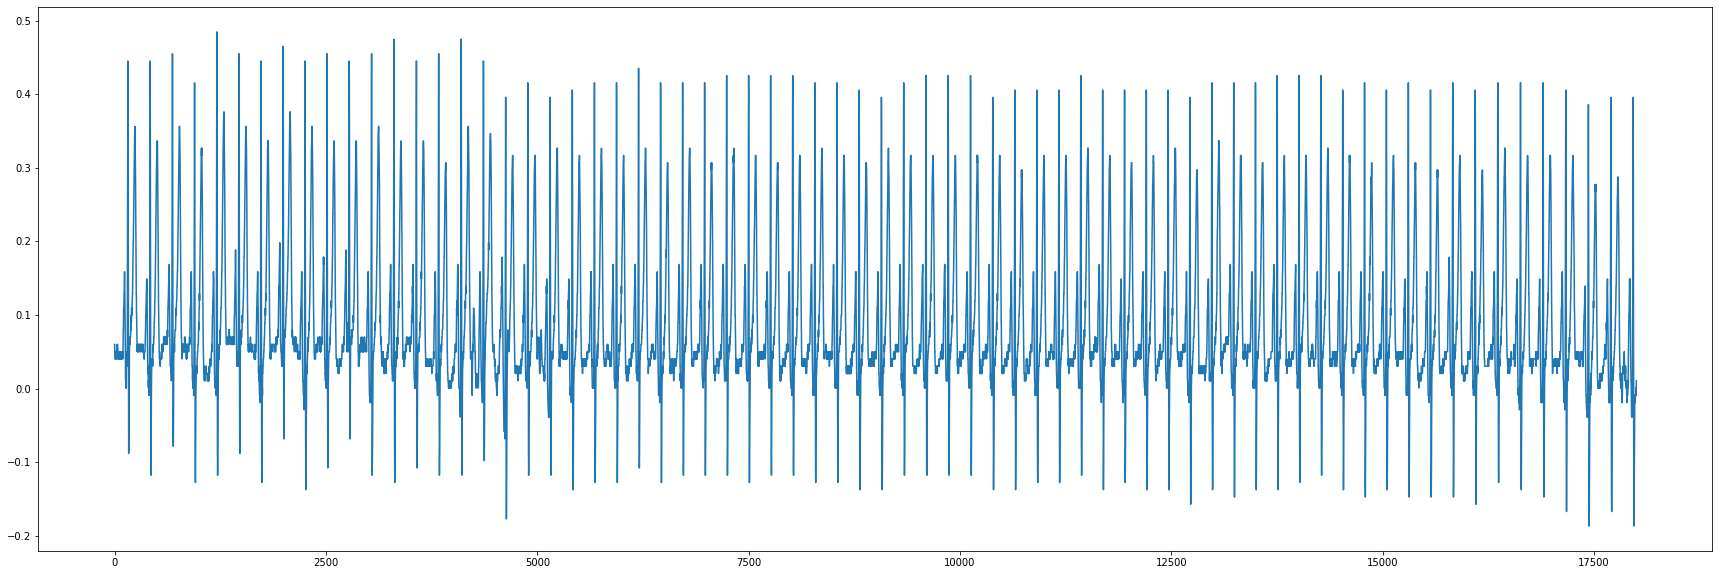

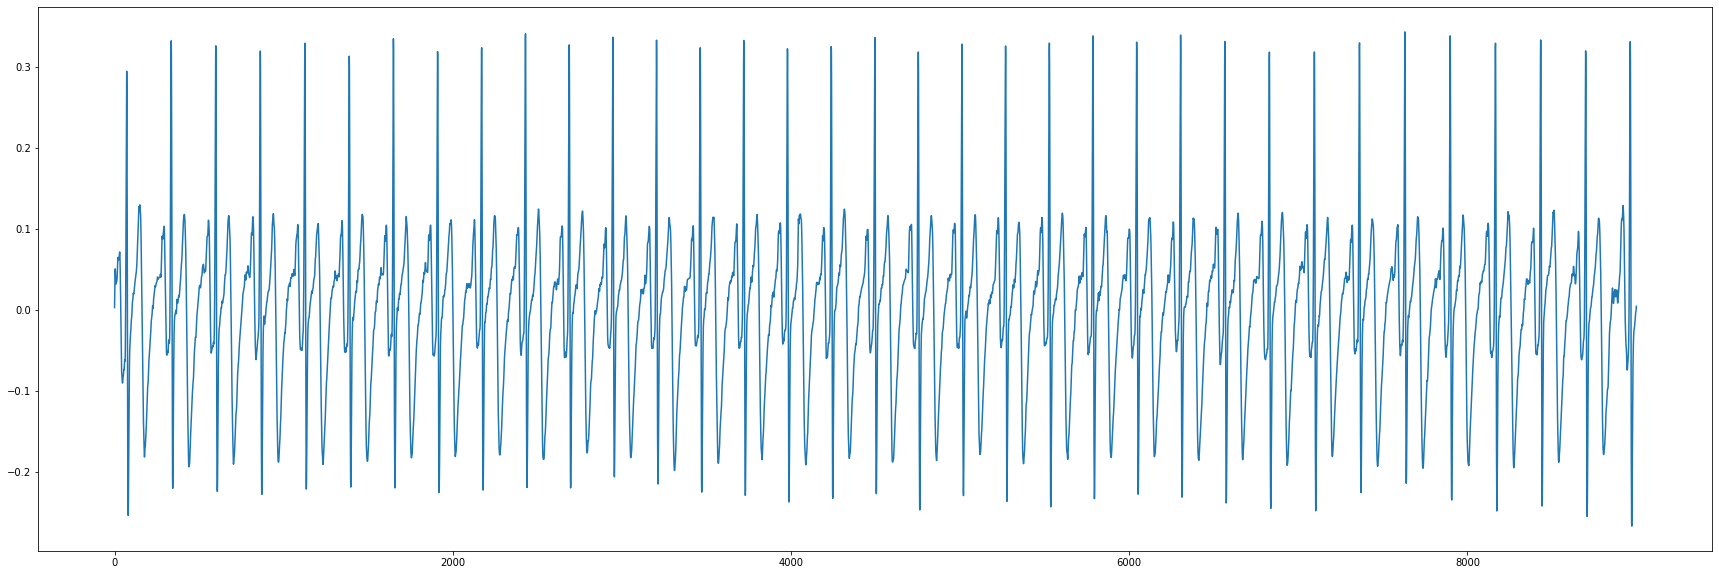

In [282]:
plt.figure(figsize=(30,10))
plt.plot(vals['nECG'])

plt.figure(figsize=(30,10))
plt.plot(seg_ecg)

### Extra

In [ ]:
# age 18세 이하인 경우 제외
SRATE = 300
ECG_FILT = 'savgol'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
file_path = f'vital_to_np_pd_{SRATE}Hz'

df_preprocess = pickle.load(open(f'cache/preprocess/df_preprocess_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}', 'rb'))

df = pd.read_csv("https://api.vitaldb.net/cases")
caseid_age = list(set(df.loc[df['age'] > 18, 'caseid']))
df_prep = df_preprocess[[int(caseid) in caseid_age for caseid in df_preprocess['caseid']]]

pickle.dump(df_prep, open(f'cache/preprocess/df_preprocess_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}', 'wb'))

In [248]:
# numpy 파일 중 18세 이하는 제거
df = pd.read_csv("https://api.vitaldb.net/cases")
caseid_age = list(set(df.loc[df['age'] > 18, 'caseid']))
file_path = f'vital_to_np_pd_{SRATE}Hz'
for file in os.listdir(file_path):
    if not 'npz' in file:
        continue
    
    caseid = file[:-4]
    if int(caseid) not in caseid_age:
        print(caseid)
        os.remove(f'{file_path}/{caseid}.npz')

2419
4337
4386
3425
533
1328
5411
4791
5266
1911
2152
4016
4184
